# Data processing and visualization




#### Walid Massaoudi 
#### bachelor project : Lora mapper with chirpstack
#### Jul-2021
The objectif of this application is to process uploaded data from influxDB or from a csv file and vizualize the results.The current application disscuss diffrents method of visualization and a final result that use geogson to implement a heat map of different key (rssi,frequency,datarate...). 

### 1 : import library 

In [133]:
import os
from urllib.request import urlretrieve
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import json
import numpy as np
import timeit 
from datetime import datetime
from datetime import datetime

from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

from scipy.interpolate import griddata
from numpy import linspace
import plotly.express as px
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
import geojsoncontour
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
import plotly.figure_factory as ff
import plotly.graph_objects as go

### Option 1: Import  data from csv file
Kindly choose only one method of import 

In [134]:
read_file = pd.read_csv (r'.\ressources\wifx.csv')
read_file.to_excel (r'.\ressources\wifx.xlsx', index = None, header=True)
path='/Users/walid/Desktop/TravailBachelor/Wifx/JupyterProcessingVisualization/ressources/wifx.xslx'
df = pd.read_excel(r'.\ressources\wifx.xlsx')
df.columns

Index(['id', 'time', 'device_id', 'application_id', 'gateway_id', 'modulation',
       'datarate', 'snr', 'rssi', 'freq', 'f_cnt', 'latitude', 'longitude',
       'altitude', 'accuracy meters', ' hdop', ' sats', 'location provider',
       ' user_agent', ' experiment name'],
      dtype='object')

In [135]:
key_columns=['id','gateway_id', 'datarate', 'snr', 'rssi', 'freq','latitude','longitude']
df=df[key_columns]
df.shape

(10001, 8)

### Option 2: Import data from  InfluxDB

In [69]:
# You can generate a Token from the "Tokens Tab" in the UI
token = "FEFE2O_DXfqWCKXD3GHEFRmQhYohPjHQfvplBFJKe22GJd1ayWAN0C0qsLPuZsnY6fk2ldce0EBe0q0ecCEvTg=="
org = "Wifx"
bucket = "Wifx" #simmilar to the database name

#inisialize the client 
client = InfluxDBClient(url="http://localhost:8086", token=token)
query_api = client.query_api()

# you can define the range of uploaded dta in this case we will take a value of 10 hours
query = 'from(bucket:"Wifx")\
|> range(start: -10h)'

result = client.query_api().query(org=org, query=query)
results = []
for table in result:
    for record in table.records:
        results.append((record.get_value(), record.get_field()))
        
# convert incomping data to a dataframe
key_columns=['id','gateway_id', 'datarate', 'snr', 'rssi', 'frequency','latitude','longitude']  
# Calling DataFrame constructor  

dfi = pd.DataFrame(columns = ['id']) 
dfg=pd.DataFrame(columns =['gateway_id']) 
dfr=pd.DataFrame(columns =['datarate']) 
dfsn=pd.DataFrame(columns =['snr']) 
dfrs=pd.DataFrame(columns =['rssi']) 
dffr=pd.DataFrame(columns =['frequency']) 
dflat=pd.DataFrame(columns =['latitude']) 
dflon=pd.DataFrame(columns =['longitude']) 
df = pd.DataFrame() 


for mes in results:
    #print(mes[1])
    if(mes[1]=='data_rate'):
     dfr = dfr.append({'datarate': mes[0]}, ignore_index=True)
    
    if(mes[1]=='gateway_id'):
     dfg = dfg.append({'gateway_id': mes[0]}, ignore_index=True)
    
    if(mes[1]=='rssi'):
     dfrs = dfrs.append({'rssi': mes[0]}, ignore_index=True)
    
    if(mes[1]=='snr'):
     dfsn = dfsn.append({'snr': mes[0]}, ignore_index=True)
    
    if(mes[1]=='longitude'):
     dflon = dflon.append({'longitude': mes[0]}, ignore_index=True)
    
    if(mes[1]=='latitude'):
     dflat = dflat.append({'latitude': mes[0]}, ignore_index=True)
    
    if(mes[1]=='id'):
     dfi = dfi.append({'id': mes[0]}, ignore_index=True)
    if(mes[1]=='frequency'):
     dffr = dffr.append({'frequency': mes[0]}, ignore_index=True)
    
frames=[dfi,dffr,dfr,dfg,dfrs,dfsn,dfsn,dflon,dflat]
df = pd.concat(frames, axis=1)
print (df)

      id  frequency datarate    gateway_id rssi snr snr  longitude   latitude
0     97      868.5       12  wO5A//8pRjM=  -44   6   6   6.615667  46.779250
1     98      867.3       12  wO5A//8pRjM=  -42   6   6   6.615667  46.779200
2     99      868.3       12  wO5A//8pRjM=  -43   6   6   6.615667  46.779233
3    100      868.5       12  wO5A//8pRjM=  -42   6   6   6.615500  46.779233
4    101      867.7       12  wO5A//8pRjM=  -43   6   6   6.615500  46.779250
..   ...        ...      ...           ...  ...  ..  ..        ...        ...
116   16      867.5       12  wO5A//8pRjM=  -39   5   5   6.615500  46.779400
117   17      867.1       12  wO5A//8pRjM=  -41   6   6   6.615500  46.779467
118   18      867.1       12  wO5A//8pRjM=  -42   5   5   6.615500  46.779533
119   19      868.3       12  wO5A//8pRjM=  -41   6   6   6.615667  46.779500
120   20      868.5       12  wO5A//8pRjM=  -44   6   6   6.615667  46.779517

[121 rows x 9 columns]


### 3 : Restrecting the area to Yverdon les bains
for a better analysis in our example we will restrict the spatial area to Yverdon les Bains district

In [136]:
df=df.query(" latitude>46.75 and latitude<46.81")
df=df.query(" longitude>6.50 and longitude<6.71")

In [137]:
df.groupby("gateway_id", as_index=False).count()[["gateway_id","id"]].sort_values(by="id",ascending=False).head(10)

,gateway_id,id
11,eui-fcc23dfffe0b6f64,2714
12,eui-fcc23dfffe0b717d,2070
15,eui-fcc23dfffe0dc680,1711
4,eui-7276ff002e062669,201
7,eui-fcc23dfffe0b67fc,184
19,eui-fcc23dfffe0f589a,178
20,eui-fcc23dfffe0f58f5,170
14,eui-fcc23dfffe0b98c9,165
6,eui-fcc23dfffe0b66dc,161
17,eui-fcc23dfffe0ef51f,159


### 4 : Basic Visualization using  Scattermapbox

In [138]:
center_coors=46.784832, 6.637715

In [139]:
trace0=go.Scattermapbox(
            lat=df.latitude,
            lon=df.longitude,
            mode='markers',
            marker=dict(
                opacity=0.5, 
                size=10, 
                color=df.rssi,        
                colorscale="jet",
                cauto=False,
                cmax=-60,
                showscale=True),
                text=df.rssi,                 
            )

data=[trace0]

layout = go.Layout(
    title="Coverage map : rssi (dBm)",  
    title_x=0.4,
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(    
        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )
)
figure=go.Figure(
    data=data,
    layout=layout,
  
    )
iplot(figure)

### 5 : Grid Scattermapbox :  Rounding Latitude and longitude 

Rounding Lat and Lon allows us to create a grid with step size equivalent to chosen rounding num. A coefficient dividing rounding num by 2 for latitude is recommended for geography of Europe, as it makes the grid tiles similar to squares. Without this correction, the grid consists of rectangles with longitude side nearly 2 times longer

In [140]:
#rounding coordinates by chosen precision creates a grid
rounding_num=0.015 
df["lon_mod"]=np.round(df.longitude/rounding_num,0)*rounding_num

#adjusting for difference in actual distance between same numeric change in lat and lon to create a square grid
correction_coeff=0.5
df["lat_mod"]=np.round(df.latitude/(rounding_num*correction_coeff),0)*(rounding_num*correction_coeff)
df["lon_mod"]=np.round(df["lon_mod"],4)
df["lat_mod"]=np.round(df["lat_mod"],4)


In [141]:
# Creating grid dataframe with average rssi for each tile. Excluding tiles with sample below 3 as insufficient samples. 
df_map=df[["lat_mod","lon_mod","rssi"]].groupby(["lat_mod","lon_mod"], as_index=False).mean()
#df_map["sample_size"]=df[["lat_mod","lon_mod","id"]].groupby(["lat_mod","lon_mod"], as_index=False).count().id
df_map["gateway_id"]=df[["lat_mod","lon_mod","gateway_id"]].groupby(["lat_mod","lon_mod"], as_index=False).first().gateway_id
df_map["gateway_id"]=np.where(df_map.gateway_id.isna(),"Other",df_map.gateway_id)
#df_map=df_map.query("sample_size>3")
df_map.reset_index(inplace=True)
df_map["geo_Id"]=df_map.index

In [142]:
df_map.shape

(35, 6)

In [143]:
data=[]
trace0=dict(
            lat=df_map.lat_mod,
            lon=df_map.lon_mod,
          
            type="scattermapbox",
            mode='markers',
            marker=dict(

                size=18, 
                color=df_map.rssi,
                opacity=0.6,
                colorscale="jet",
                cauto=False,
                cmax=-80,
                showscale=True),
                text=df_map.rssi,     
            )

data=[trace0]

layout = go.Layout(
    title="Grid average rssi density",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=dict(
    data=data,
    layout=layout
    )
iplot(figure)

### 6 : Choroplet maps
Scatter plots work well with maps, but they tend to be too crowded, on the other hand, the other surface plots are easier to read, but cannot be combined with a map using plotly. A choropleth map with custom created geojson object will probably be the best solution.

##### Initial approach to grid based choropleth map¶
To start working with choropleth maps, let's try to create our custom geojson, which will form a grid.


In [144]:
df_map

,index,lat_mod,lon_mod,rssi,gateway_id,geo_Id
0,0,46.7475,6.615,-108.166667,eui-fcc23dfffe0b6f64,0
1,1,46.7550,6.615,-112.562500,eui-fcc23dfffe0b717d,1
2,2,46.7550,6.630,-109.229885,eui-fcc23dfffe0dc680,2
3,3,46.7550,6.645,-108.857143,eui-fcc23dfffe0dc680,3
4,4,46.7550,6.660,-111.333333,eui-fcc23dfffe0dc680,4
5,5,46.7625,6.525,-114.500000,eui-fcc23dfffe0b6f64,5
6,6,46.7625,6.630,-105.818966,eui-fcc23dfffe0b6f64,6
7,7,46.7625,6.645,-107.580029,eui-fcc23dfffe0b66dc,7
8,8,46.7625,6.660,-110.071429,eui-fcc23dfffe0b6f64,8
9,9,46.7700,6.630,-107.351351,eui-fcc23dfffe0b6f64,9


In [145]:
geo_list=[]

for i in range(0,df_map.shape[0]):
    point=df_map.iloc[i,:]
    geo_json={}
    geo_json["type"]="Feature"
    geo_json["properties"]={"gateway_id":point.gateway_id}
    
    geo_json["geometry"]={
        "type":"Polygon",
        "coordinates":[[[point.lon_mod+rounding_num/2,point.lat_mod+rounding_num*correction_coeff/2],
                        [point.lon_mod-rounding_num/2,point.lat_mod+rounding_num*correction_coeff/2],
                        [point.lon_mod-rounding_num/2,point.lat_mod-rounding_num*correction_coeff/2],
                        [point.lon_mod+rounding_num/2,point.lat_mod-rounding_num*correction_coeff/2]]]}
        
    geo_json["id"]=i
    
    geo_list.append(geo_json)

In [146]:
grid_geojson={"type":"FeatureCollection","features":geo_list}

In [147]:
trace = go.Choroplethmapbox(
                            geojson=grid_geojson,
                            locations=df_map.geo_Id,
                            z=df_map.rssi,
                            colorscale="jet", 
                            #text=df_map.sample_size,
                            marker_line_width=0,

                            marker=dict(opacity=0.5),

                           )
layout = go.Layout(
    title="Grid average rssi [dBm] - choropleth grid",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 10,
        # default map style
        style = "carto-positron"
    )

)

figure=dict(
    data=[trace],
    layout=layout,
  
    )

iplot(figure)

### 7 :  Custom heatmaps with geojson
For me the best solution turned out to be a 4 step process:
- Creating a contour plot in matplotlib
- Converting it to geojson with use of geojsoncountour library
- Extracting values from geojson to df_contour
- Creating a choropleth map using plotly


Custom geojsons can be created to represent contour plots. Creating a countour plot will make it easier to distinct boundaries between rssi areas within gateways.
#### Countour plot with matplotlib

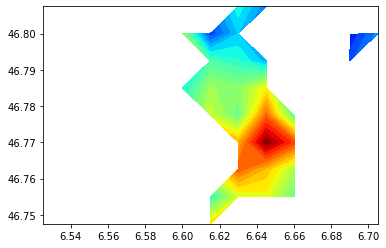

In [148]:
df_piv=pd.pivot_table(df, values="rssi", index=df.lat_mod, columns=df.lon_mod, aggfunc=np.mean)
z=df_piv.values
y=df_piv.index
x=df_piv.columns
cs=plt.contourf(x,y,z,levels=30,cmap="jet")

In [149]:
df_map.shape

(35, 6)

In [150]:
#Extrating x,y and values (z)
z=df_map.rssi
y=df_map.lat_mod
x=df_map.lon_mod

In [151]:
#Interpolating values to get better coverage
xi = linspace(x.min(),x.max(),20);
yi = linspace(y.min(),y.max(),20);
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

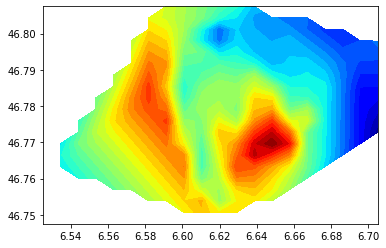

In [159]:
#Creating contour plot with a step size of 10
step_size=1



cs = plt.contourf(xi,yi,zi,levels=30,cmap=plt.cm.jet)

In [160]:
geojson = geojsoncontour.contourf_to_geojson(
    contourf=cs,
    ndigits=3,
)
mes_geojson=eval(geojson)
mes_geojson

{'features': [{'geometry': {'coordinates': [[[[6.703, 46.772],
       [6.705, 46.773],
       [6.705, 46.775],
       [6.703, 46.773],
       [6.703, 46.772]]]],
    'type': 'MultiPolygon'},
   'properties': {'fill': '#000092',
    'fill-opacity': 0.9,
    'stroke': '#000092',
    'stroke-opacity': 1,
    'stroke-width': 1,
    'title': '-119.00--118.50 '},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[[6.7, 46.771],
       [6.703, 46.772],
       [6.703, 46.773],
       [6.705, 46.775],
       [6.705, 46.776],
       [6.705, 46.778],
       [6.702, 46.776],
       [6.7, 46.773],
       [6.7, 46.771]]]],
    'type': 'MultiPolygon'},
   'properties': {'fill': '#0000b6',
    'fill-opacity': 0.9,
    'stroke': '#0000b6',
    'stroke-opacity': 1,
    'stroke-width': 1,
    'title': '-118.50--118.00 '},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[[6.697, 46.77],
       [6.7, 46.771],
       [6.7, 46.773],
       [6.702, 46.776],
       [6.705, 46.778],
       [6.705,

In [161]:
mes_geojson.keys()

dict_keys(['features', 'type'])

In [162]:
print(mes_geojson["features"][0])

{'geometry': {'coordinates': [[[[6.703, 46.772], [6.705, 46.773], [6.705, 46.775], [6.703, 46.773], [6.703, 46.772]]]], 'type': 'MultiPolygon'}, 'properties': {'fill': '#000092', 'fill-opacity': 0.9, 'stroke': '#000092', 'stroke-opacity': 1, 'stroke-width': 1, 'title': '-119.00--118.50 '}, 'type': 'Feature'}


In [163]:

arr_temp=np.ones([len(mes_geojson["features"]),2])

for i in range(0, len(mes_geojson["features"])):
    mes_geojson["features"][i]["id"]=i

#Filling array with price and Id for each geojson spatial object. Z value from contour plot will be stored as title
    arr_temp[i,0]=i
    arr_temp[i,1]=float((mes_geojson["features"][i]["properties"]["title"]).split("--", 1)[0])
#Transforming array to df
df_contour=pd.DataFrame(arr_temp, columns=["id","rssi"])

In [164]:
trace = go.Choroplethmapbox(
                            geojson=mes_geojson,
                            locations=df_contour.id,
                            z=df_contour.rssi,
                            colorscale="jet",  
                            marker_line_width=0,

                            marker=dict(opacity=0.5)
                           )



layout = go.Layout(
    title="RSSI heatmap",  
    title_x=0.4,
   
    
    
    height = 800,
    # top, bottom, left and right margins
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
 
    mapbox = dict(
       

        center = dict(
            lat = center_coors[0],
            lon = center_coors[1]
        ),
        # default level of zoom
        zoom = 11,
        # default map style
        style = "carto-positron"
    )

)

figure=dict(
    data=[trace],
    layout=layout,
  
    )

iplot(figure)